## Eksplorasi Data
Memahami dataset, memeriksa distribusi, dan mengidentifikasi potensi masalah (misalnya, missing values, imbalance).

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
# Load dataset
data = pd.read_csv('Datasets_Complete.csv')

In [66]:
# Tampilkan informasi dasar
print("Info Dataset:")
print(data.info())
print("\nDeskripsi Statistik:")
print(data.describe())

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Timestamp               40000 non-null  object 
 1   Source IP Address       40000 non-null  object 
 2   Destination IP Address  40000 non-null  object 
 3   Source Port             40000 non-null  int64  
 4   Destination Port        40000 non-null  int64  
 5   Protocol                40000 non-null  object 
 6   Packet Length           40000 non-null  int64  
 7   Packet Type             40000 non-null  object 
 8   Traffic Type            40000 non-null  object 
 9   Payload Data            40000 non-null  object 
 10  Malware Indicators      40000 non-null  object 
 11  Anomaly Scores          40000 non-null  float64
 12  Alerts/Warnings         40000 non-null  object 
 13  Attack Type             40000 non-null  object 
 14  Attack Signature        

In [67]:
# Periksa missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
Timestamp                     0
Source IP Address             0
Destination IP Address        0
Source Port                   0
Destination Port              0
Protocol                      0
Packet Length                 0
Packet Type                   0
Traffic Type                  0
Payload Data                  0
Malware Indicators            0
Anomaly Scores                0
Alerts/Warnings               0
Attack Type                   0
Attack Signature              0
Action Taken                  0
Severity Level                0
User Information              0
Device Information            0
Network Segment               0
Geo-location Data             0
Proxy Information         19851
Firewall Logs             19961
IDS/IPS Alerts            20050
Log Source                    0
dtype: int64


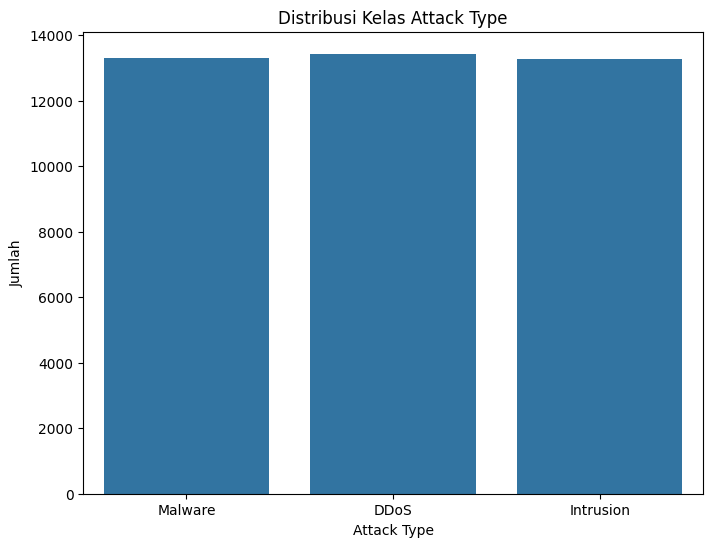

In [68]:
# Distribusi kelas
plt.figure(figsize=(8, 6))
sns.countplot(x='Attack Type', data=data)
plt.title('Distribusi Kelas Attack Type')
plt.xlabel('Attack Type')
plt.ylabel('Jumlah')
plt.show()

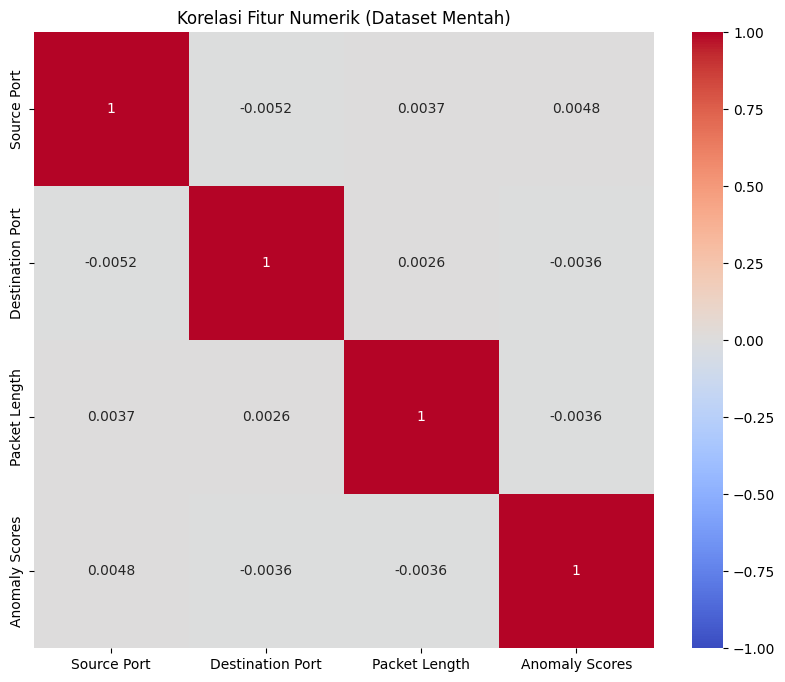

In [69]:
# Periksa korelasi awal (hanya fitur numerik yang ada di dataset mentah)
numeric_features = ['Source Port', 'Destination Port', 'Packet Length']  # Hapus fitur yang belum ada
if 'Anomaly Scores' in data.columns:
    numeric_features.append('Anomaly Scores')  # Tambahkan hanya jika ada di dataset
else:
    print("Peringatan: Kolom 'Anomaly Scores' tidak ditemukan di dataset mentah.")

plt.figure(figsize=(10, 8))
sns.heatmap(data[numeric_features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Korelasi Fitur Numerik (Dataset Mentah)')
plt.show()

## Preprocessing
Membersihkan data dan membuat fitur baru, dengan pemisahan data sebelum preprocessing untuk mencegah leakage.

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import re

In [71]:
# Pilih fitur dan target
features = ['Source Port', 'Destination Port', 'Packet Length', 'Protocol', 'Traffic Type', 
            'Payload Data', 'Timestamp', 'Malware Indicators']
target = 'Attack Type'

X = data[features]
y = data[target]

In [72]:
# Pisahkan data sebelum preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [73]:
# Fungsi feature engineering
def extract_payload_features(payload):
    if not isinstance(payload, str):
        return 0, 0
    length = len(payload)
    malicious_keywords = len(re.findall(r'eval|whoami|==|wget|curl|exec|SELECT|UNION|WHERE|etc|passwd|.exe|.bin|anydesk.exe|powershell.exe|monlist|ps|FROM|bypass|dlink|mimikatz.exe', payload, re.IGNORECASE))
    return length, min(malicious_keywords, 1)

X_train = X_train.copy()
X_test = X_test.copy()

X_train['Payload_Length'] = X_train['Payload Data'].apply(extract_payload_features).apply(lambda x: x[0])
X_train['Payload_Malicious'] = X_train['Payload Data'].apply(extract_payload_features).apply(lambda x: x[1])
X_train['Timestamp'] = pd.to_datetime(X_train['Timestamp'], errors='coerce')
X_train['Hour'] = X_train['Timestamp'].dt.hour
X_train['Has_Malware_Indicator'] = X_train['Malware Indicators'].apply(lambda x: 1 if x != 'None' else 0)

X_test['Payload_Length'] = X_test['Payload Data'].apply(extract_payload_features).apply(lambda x: x[0])
X_test['Payload_Malicious'] = X_test['Payload Data'].apply(extract_payload_features).apply(lambda x: x[1])
X_test['Timestamp'] = pd.to_datetime(X_test['Timestamp'], errors='coerce')
X_test['Hour'] = X_test['Timestamp'].dt.hour
X_test['Has_Malware_Indicator'] = X_test['Malware Indicators'].apply(lambda x: 1 if x != 'None' else 0)

In [74]:
# Imputasi missing values
X_train['Proxy Information'].fillna('None', inplace=True) if 'Proxy Information' in X_train.columns else None
X_train['Firewall Logs'].fillna('None', inplace=True) if 'Firewall Logs' in X_train.columns else None
X_train['IDS/IPS Alerts'].fillna('None', inplace=True) if 'IDS/IPS Alerts' in X_train.columns else None

X_test['Proxy Information'].fillna('None', inplace=True) if 'Proxy Information' in X_test.columns else None
X_test['Firewall Logs'].fillna('None', inplace=True) if 'Firewall Logs' in X_test.columns else None
X_test['IDS/IPS Alerts'].fillna('None', inplace=True) if 'IDS/IPS Alerts' in X_test.columns else None

In [75]:
# Pilih fitur akhir
final_features = ['Source Port', 'Destination Port', 'Packet Length', 'Payload_Length', 
                  'Hour', 'Payload_Malicious', 'Has_Malware_Indicator', 'Protocol', 'Traffic Type']
X_train = X_train[final_features]
X_test = X_test[final_features]

In [76]:
# Preprocessor
numeric_features = ['Source Port', 'Destination Port', 'Packet Length', 'Payload_Length', 'Hour']
categorical_features = ['Protocol', 'Traffic Type', 'Has_Malware_Indicator']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

In [47]:
# Pilih fitur akhir
final_features = ['Source Port', 'Destination Port', 'Packet Length', 'Payload_Length', 
                  'Hour', 'Payload_Malicious', 'Has_Malware_Indicator', 'Protocol', 'Traffic Type']
X_train = X_train[final_features]
X_test = X_test[final_features]

# Preprocessor
numeric_features = ['Source Port', 'Destination Port', 'Packet Length', 'Payload_Length', 'Hour']
categorical_features = ['Protocol', 'Traffic Type', 'Has_Malware_Indicator']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

In [77]:
# Transformasi data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [78]:
# Encode label
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

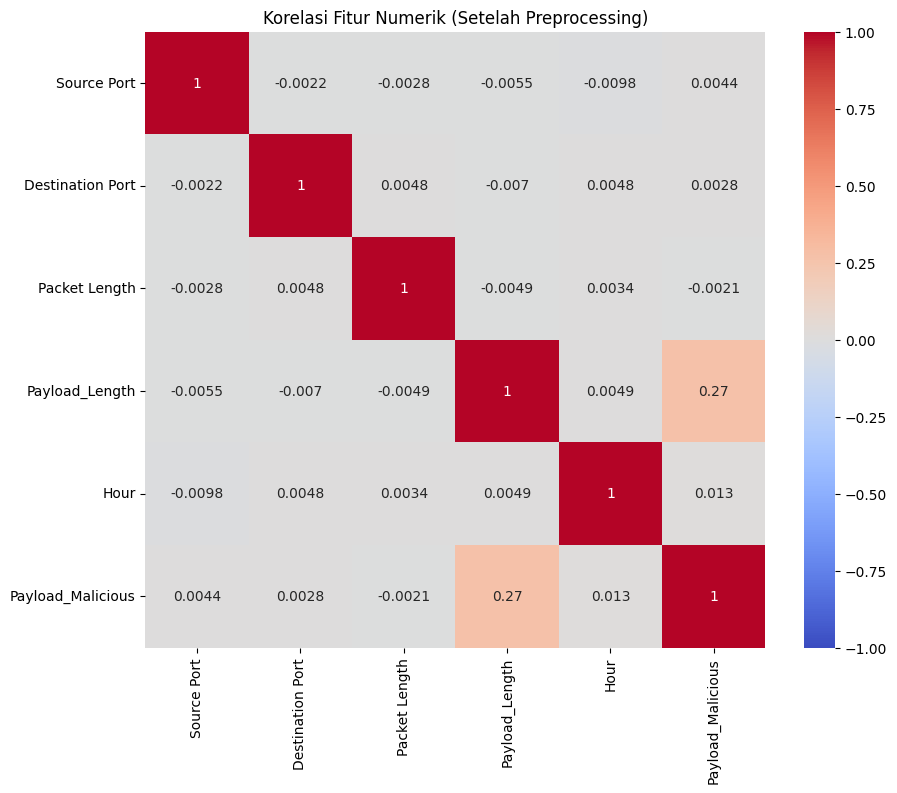

In [79]:
# Analisis korelasi setelah preprocessing
data_processed = X_train.copy()
numeric_features_processed = ['Source Port', 'Destination Port', 'Packet Length', 
                              'Payload_Length', 'Hour', 'Payload_Malicious']
plt.figure(figsize=(10, 8))
sns.heatmap(data_processed[numeric_features_processed].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Korelasi Fitur Numerik (Setelah Preprocessing)')
plt.show()

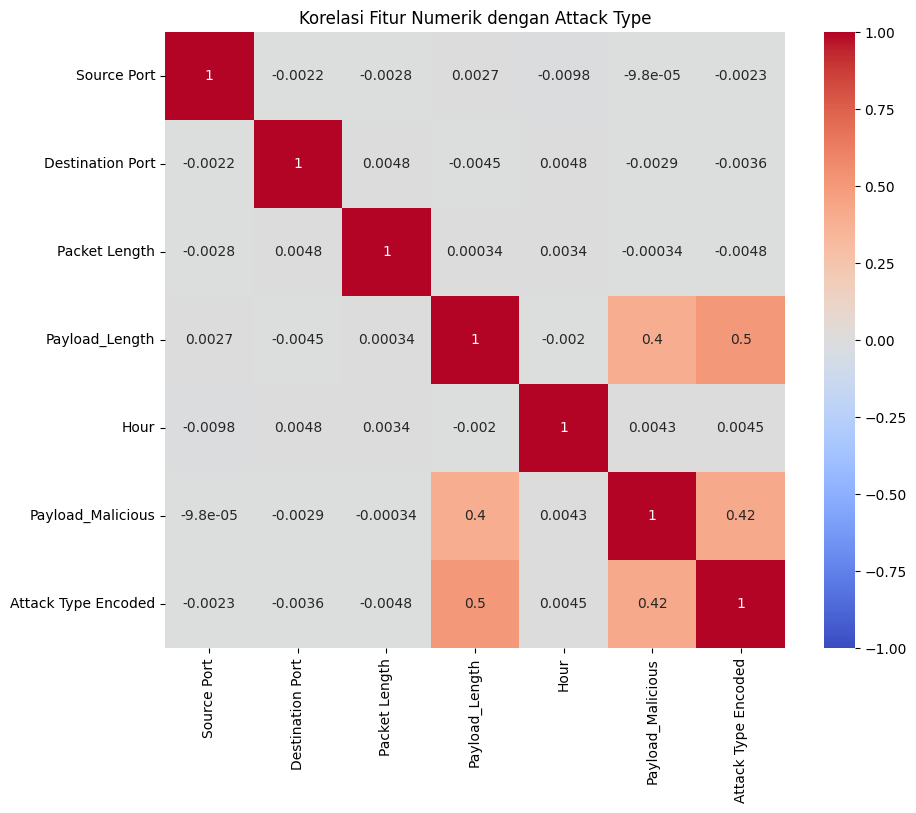

In [18]:
# Korelasi dengan target untuk deteksi leakage
data_processed['Attack Type'] = y_train
data_processed['Attack Type Encoded'] = label_encoder.transform(data_processed['Attack Type'])
numeric_features_with_target = numeric_features_processed + ['Attack Type Encoded']
plt.figure(figsize=(10, 8))
sns.heatmap(data_processed[numeric_features_with_target].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Korelasi Fitur Numerik dengan Attack Type')
plt.show()

In [80]:
print("Shape X_train_processed:", X_train_processed.shape)
print("Shape X_test_processed:", X_test_processed.shape)

Shape X_train_processed: (28000, 9)
Shape X_test_processed: (12000, 9)


## Pemilihan Fitur
Mengidentifikasi fitur yang paling relevan dengan mengurangi risiko leakage.

In [81]:
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np

In [82]:
# Ambil nama fitur setelah preprocessing
numeric_features = ['Source Port', 'Destination Port', 'Packet Length', 'Payload_Length', 'Hour']
categorical_features = ['Protocol', 'Traffic Type', 'Has_Malware_Indicator']

In [83]:
# Gabungkan nama fitur numerik dan kategorikal setelah OneHotEncoding
feature_names = (numeric_features + 
                 list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

In [84]:
# Pilih fitur terbaik (misalnya, 10 fitur teratas)
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_processed, y_train_encoded)
X_test_selected = selector.transform(X_test_processed)

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=9. All the features will be returned.
  warnings.warn(


In [85]:
# Dapatkan indeks fitur yang dipilih
selected_feature_indices = selector.get_support(indices=True)

In [86]:
#Ambil nama fitur yang dipilih berdasarkan indeks
selected_feature_names = [feature_names[i] for i in selected_feature_indices]

# Tampilkan fitur yang dipilih
print("Fitur Terpilih:", selected_feature_names)

Fitur Terpilih: ['Source Port', 'Destination Port', 'Packet Length', 'Payload_Length', 'Hour', 'Protocol_TCP', 'Protocol_UDP', 'Traffic Type_FTP', 'Traffic Type_HTTP']


In [87]:
# Perbarui X_train dan X_test dengan fitur terpilih
X_train_processed = X_train_selected
X_test_processed = X_test_selected

## Pemilihan Model
Menguji beberapa model untuk memilih yang terbaik sebelum optimasi.

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report

In [89]:
# Pipeline untuk setiap model
models = {
    'Logistic Regression': Pipeline([
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('classifier', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42))
    ])
}

In [90]:
# Cross-validation untuk mencegah overfitting
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_processed, y_train_encoded, cv=cv, scoring='f1_weighted')
    print(f"\n{name} - Cross-Validation F1-Score (Weighted):")
    print(f"Mean: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")

    # Latih dan evaluasi pada data pengujian
    model.fit(X_train_processed, y_train_encoded)
    y_pred_encoded = model.predict(X_test_processed)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    print(f"\nClassification Report ({name}):")
    print(classification_report(y_test, y_pred))




Logistic Regression - Cross-Validation F1-Score (Weighted):
Mean: 0.5965, Std: 0.0092

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

        DDoS       0.73      1.00      0.84      4028
   Intrusion       0.41      0.26      0.32      3980
     Malware       0.64      0.63      0.63      3992

    accuracy                           0.63     12000
   macro avg       0.59      0.63      0.60     12000
weighted avg       0.59      0.63      0.60     12000


Random Forest - Cross-Validation F1-Score (Weighted):
Mean: 0.6981, Std: 0.0058

Classification Report (Random Forest):
              precision    recall  f1-score   support

        DDoS       0.80      1.00      0.89      4028
   Intrusion       1.00      0.26      0.41      3980
     Malware       0.67      1.00      0.80      3992

    accuracy                           0.75     12000
   macro avg       0.82      0.75      0.70     12000
weighted avg       0.82      0.75      

## Pemilihan Model (Random Forest)
Menggunakan Random Forest sebagai model yang dipilih, dengan cross-validation untuk memastikan performa yang konsisten dan mencegah overfitting.

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report

In [92]:
# Pipeline untuk Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Tambahkan langkah preprocessor
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42))
])

In [93]:
# Cross-validation untuk mencegah overfitting
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_pipeline, X_train, y_train_encoded, cv=cv, scoring='f1_weighted')
print("Random Forest - Cross-Validation F1-Score (Weighted):")
print(f"Mean: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")

Random Forest - Cross-Validation F1-Score (Weighted):
Mean: 0.6981, Std: 0.0058


In [94]:
# Latih dan evaluasi pada data pengujian (awal, sebelum optimasi)
rf_pipeline.fit(X_train, y_train_encoded)
y_pred_encoded = rf_pipeline.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)
print("\nClassification Report (Random Forest - Awal):")
print(classification_report(y_test, y_pred))


Classification Report (Random Forest - Awal):
              precision    recall  f1-score   support

        DDoS       0.80      1.00      0.89      4028
   Intrusion       1.00      0.26      0.41      3980
     Malware       0.67      1.00      0.80      3992

    accuracy                           0.75     12000
   macro avg       0.82      0.75      0.70     12000
weighted avg       0.82      0.75      0.70     12000



## Pelatihan Model (RF)
Melatih model Random Forest dengan data pelatihan dan menyimpan model untuk digunakan di tahap berikutnya.

In [95]:
# Latih model Random Forest dengan pipeline yang sudah mencakup preprocessor
rf_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Source Port',
                                                   'Destination Port',
                                                   'Packet Length',
                                                   'Payload_Length', 'Hour']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Protocol', 'Traffic Type',
                                                   'Has_Malware_Indicator'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=5, random_state=42))])

In [96]:
# Simpan model dan LabelEncoder
import joblib
joblib.dump(rf_pipeline, 'attack_type_classifier_rf.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
print("Model Random Forest dan LabelEncoder disimpan.")

Model Random Forest dan LabelEncoder disimpan.


## Evaluasi Model (RF)
Mengevaluasi performa Random Forest pada data pengujian menggunakan metrik seperti classification report dan confusion matrix.

In [97]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [98]:
# Prediksi pada data pengujian
y_pred_encoded = rf_pipeline.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

In [99]:
# Classification Report
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred))


Classification Report (Random Forest):
              precision    recall  f1-score   support

        DDoS       0.80      1.00      0.89      4028
   Intrusion       1.00      0.26      0.41      3980
     Malware       0.67      1.00      0.80      3992

    accuracy                           0.75     12000
   macro avg       0.82      0.75      0.70     12000
weighted avg       0.82      0.75      0.70     12000



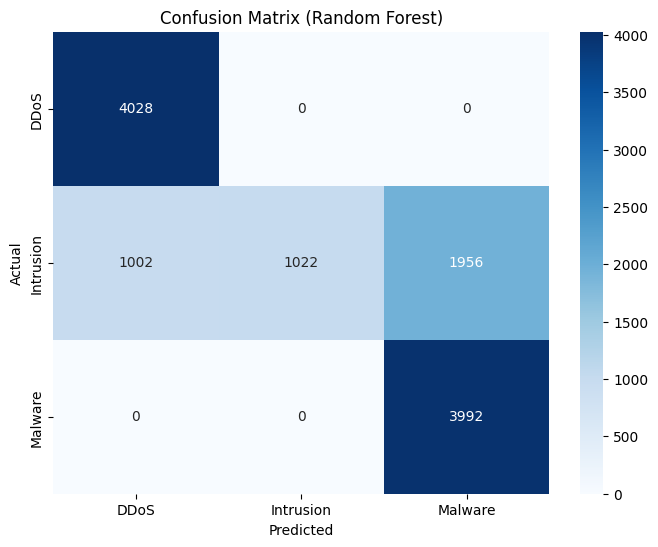

In [100]:
# Visualisasi Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=label_encoder.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig('confusion_matrix_rf.png')
plt.show()

## Optimasi Model (RF)
Tujuan: Mengoptimalkan hiperparameter Random Forest menggunakan GridSearchCV untuk meningkatkan performa dan mencegah overfitting.

In [101]:
from sklearn.model_selection import GridSearchCV

In [102]:
## Parameter grid untuk Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

In [103]:
# GridSearchCV untuk optimasi hiperparameter
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1
)

grid_search.fit(X_train, y_train_encoded)

print("\nParameter Terbaik:", grid_search.best_params_)
print("F1-Score Terbaik:", grid_search.best_score_)


Parameter Terbaik: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
F1-Score Terbaik: 0.8642281827119096


In [104]:
# Gunakan model terbaik
best_rf_model = grid_search.best_estimator_

# Simpan model yang dioptimalkan
joblib.dump(best_rf_model, 'attack_type_classifier_rf_optimized.pkl')
print("Model Random Forest yang dioptimalkan disimpan.")

Model Random Forest yang dioptimalkan disimpan.


## Pengujian Akhir (RF)
Tujuan: Menguji model Random Forest yang dioptimalkan pada data baru dengan simulasi noise untuk memastikan generalisasi dan mendeteksi potensi overfitting.

In [105]:
import numpy as np

In [106]:
# Simulasi data baru dari X_test
new_log_data = X_test.sample(100, random_state=123)
new_log_labels = y_test.loc[new_log_data.index]

In [107]:
# Tambahkan noise untuk menguji robustitas
new_log_data_noisy = new_log_data.copy()
numeric_features = ['Source Port', 'Destination Port', 'Packet Length', 'Payload_Length', 'Hour']
new_log_data_noisy[numeric_features] += np.random.normal(0, 0.1, new_log_data_noisy[numeric_features].shape)

In [108]:
# Prediksi menggunakan pipeline (yang sudah mencakup preprocessor)
new_predictions_encoded = best_rf_model.predict(new_log_data_noisy)
new_predictions = label_encoder.inverse_transform(new_predictions_encoded)

In [109]:
# Evaluasi pada data baru
print("\nClassification Report (Data Baru dengan Noise):")
print(classification_report(new_log_labels, new_predictions))


Classification Report (Data Baru dengan Noise):
              precision    recall  f1-score   support

        DDoS       0.80      1.00      0.89        35
   Intrusion       0.96      0.59      0.73        37
     Malware       0.82      0.96      0.89        28

    accuracy                           0.84       100
   macro avg       0.86      0.85      0.83       100
weighted avg       0.86      0.84      0.83       100



In [3]:
import sklearn
import pandas
import seaborn
import matplotlib
print("Versi scikit-learn:", sklearn.__version__)
print("Versi pandas:", pandas.__version__)
print("Versi seaborn:", seaborn.__version__)
print("Versi matplotlib:", matplotlib.__version__)

Versi scikit-learn: 1.5.2
Versi pandas: 2.2.3
Versi seaborn: 0.13.2
Versi matplotlib: 3.9.4
